# Building Synapse Models

@[Chaoming Wang](https://github.com/chaoming0625) @[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) 

Synaptic computation is the core of brain dynamics programming. This is beacuse in a real project most of the simulation time spends on the computation of synapses. In order to achieve efficient synaptic computation, BrainPy provides many useful supports. Here, we are going to explore the details of these supports. 

In [1]:
import brainpy as bp
import brainpy.math as bm

# bm.set_platform('cpu')

## Synapse Models in Math

Before we talk about the implementation of synapses in BrainPy, it's better to understand the targets (synapse models) we are going to implement. For different illustration purposes, we are going to implement two synapse models: [exponential synapse model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.synapses.DualExpCOBA.html) and [AMPA synapse model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.synapses.AMPA.html).

### 1. The exponential synapse model

The exponential synapse model assumes that once a pre-synaptic neuron generates a spike, the synaptic state arises instantaneously, then decays with a certain time constant $\tau_{decay}$. Its dynamics is given by:

$$
\frac{d g}{d t} = -\frac{g}{\tau_{decay}}+\sum_{k} \delta(t-D-t^{k})
$$

where $g$ is the synaptic state, $t^{k}$ is the spike time of the pre-synaptic neuron, and $D$ is the synaptic delay. 

Afterward, the current output onto the post-synaptic neuron is given in the conductance-based form:

$$
I_{syn}(t) = g_{max} g \left( V-E \right)
$$

where $E$ is the reversal potential of the synapse, $V$ is the post-synaptic membrane potential, $g_{max}$ is the maximum synaptic conductance. 

### 2. The AMPA synapse model

A classical model of AMPA synapse is to use the Markov process to model ion channel switch. Here $g$ represents the probability of channel opening, $1-g$ represents the probability of ion channel closing, and $\alpha$ and $\beta$ are the transition probability. Specifically, its formula is given by

$$
\frac{dg}{dt} =\alpha[T](1-g)-\beta g
$$

where $\alpha [T]$ denotes the transition probability from state $(1-g)$
to state $(g)$; and $\beta$ represents the transition probability of
the other direction. $\alpha$ is the binding constant. $\beta$ is the
unbinding constant. $[T]$ is the neurotransmitter concentration, and
has the duration of 0.5 ms.

Moreover, the post-synaptic current on the post-synaptic neuron is formulated as

$$I_{syn} = g_{max} g (V-E)$$

where $g_{max}$ is the maximum conductance, and $E$ is the reverse potential.

## Synapse Models in Silicon

The implementation of synapse models is accomplished by ``brainpy.dyn.TwoEndConn`` interface. In this section, we talk about what supports are provided for the implementation of synapse models in silicon. 

### 1. ``brainpy.dyn.TwoEndConn``

In BrainPy, `brainpy.dyn.TwoEndConn` is used to model two-end synaptic computations.

To define a synapse model, two requirements should be satisfied:

1\. Constructor function ``__init__()``, in which three key arguments are needed.
  - `pre`: the pre-synaptic neural group. It should be an instance of `brainpy.dyn.NeuGroup`.
  - `post`: the post-synaptic neural group. It should be an instance of `brainpy.dyn.NeuGroup`.
  - `conn` (optional): the connection type between these two groups. BrainPy has provided abundant connection types that are described in details in the [Synaptic Connections](../tutorial_toolbox/synaptic_connections.ipynb).

2\. Update function ``update(_t, _dt)`` describes the updating rule from the current time $\mathrm{\_t}$ to the next time $\mathrm{\_t + \_dt}$.

### 2. Variable delays

As seen in the above two synapse models, synaptic computations are usually involved with variable delays. A delay time (typically 0.3–0.5 ms) is usually required for a neurotransmitter to be released from a presynaptic membrane, diffuse across the synaptic cleft, and bind to a receptor site on the post-synaptic membrane.

BrainPy provides several kinds of delay variables for users, including:

- ``brainpy.math.LengthDelay``: a delay variable which defines a constant steps for delay.
- ``brainpy.math.TimeDelay``: a delay variable which defines a constant time length for delay.

Assume here we need a delay variable which has 1 ms delay. If the numerical integration precision ``dt`` is 0.1 ms, then we can create a ``brainpy.math.LengthDelay`` which has  10 delay time steps.

In [2]:
target_data_to_delay = bm.Variable(bm.zeros(10))

example_delay = bm.LengthDelay(target_data_to_delay,
                               delay_len=10)  # delay 10 steps

In [3]:
example_delay(5)  # call the delay data at 5 delay step

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [4]:
example_delay(10)  # call the delay data at 10 delay step

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Alternatively, we can create an instance of ``brainpy.math.TimeDelay``, which use time ``t`` as the index to retrieve the delay data.

In [5]:
t0 = 0.
example_delay = bm.TimeDelay(target_data_to_delay,
                             delay_len=1.0, t0=t0)  # delay 1.0 ms

In [6]:
example_delay(t0 - 1.0)  # the delay data at t-1. ms

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [7]:
example_delay(t0 - 0.5)  # the delay data at t-0.5 ms

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### 3. Synaptic connections

Synaptic computations usually need to create connection between groups. BrainPy provides many wonderful supports to construct [synaptic connections](./synaptic_connections.ipynb). Simply speaking, ``brainpy.conn.Connector`` can create various data sturctures you want through the ``require()`` function. Take the random connection ``brainpy.conn.FixedProb`` which will be used in follows as the example, 

In [8]:
example_conn = bp.conn.FixedProb(0.2)(pre_size=(5,), post_size=(8, ))

we can require the connection matrix (has the shape of ``(num_pre, num_post)``:

In [9]:
example_conn.require('conn_mat')

JaxArray([[False, False, False, False,  True, False, False, False],
          [False, False, False, False, False, False,  True, False],
          [False, False, False, False, False,  True, False, False],
          [False, False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False, False]],            dtype=bool)

we can also require the connected indices of pre-synaptic neurons (``pre_ids``) and post-synaptic neurons (``post_ids``):

In [10]:
example_conn.require('pre_ids', 'post_ids')

(JaxArray([0, 0, 1, 1, 2, 2, 3, 4, 4, 4, 4], dtype=uint32),
 JaxArray([1, 4, 4, 5, 2, 3, 6, 1, 5, 6, 7], dtype=uint32))

Or, we can require the connection structure of ``pre2post`` which stores the information how does each pre-synaptic neuron connect to post-synaptic neurons:

In [11]:
example_conn.require('pre2post')

(JaxArray([0, 3, 4, 1, 0, 2, 7], dtype=uint32),
 JaxArray([0, 3, 3, 4, 7, 7], dtype=uint32))

More details of the connection structures please see the tutorial of [Synaptic Connections](../tutorial_toolbox/synaptic_connections.ipynb).

### Achieving efficient synaptic computation is difficult

Synaptic computations usually need to transform the data of the pre-synaptic dimension into the data of the post-synaptic dimension, or the data with the shape of the synapse number. There does not exist a universal computation method that are efficient in all cases. Usually, we need different ways for different connection situations to achieve efficient synaptic computation. In the next two sections, we will talk about how to define efficient synaptic models when your connections are **sparse** or **dense**.   

Before we start, we need to define some useful helper functions to define and show synapse models. Then, we will highlight the key differences of model difinition when using different synaptic connections. 

In [12]:
# Basic Model to define the exponential synapse model. This class 
# defines the basic parameters, variables, and integral functions. 


class BaseExpSyn(bp.dyn.TwoEndConn):
  def __init__(self, pre, post, conn, g_max=1., delay=0., tau=8.0, E=0., method='exp_auto'):
    super(BaseExpSyn, self).__init__(pre=pre, post=post, conn=conn)

    # check whether the pre group has the needed attribute: "spike"
    self.check_pre_attrs('spike')

    # check whether the post group has the needed attribute: "input" and "V"
    self.check_post_attrs('input', 'V')

    # parameters
    self.E = E
    self.tau = tau
    self.delay = delay
    self.g_max = g_max

    # use "LengthDelay" to store the spikes of the pre-synaptic neuron group
    self.delay_step = int(delay/bm.get_dt())
    self.pre_spike = bm.LengthDelay(pre.spike, self.delay_step)

    # integral function
    self.integral = bp.odeint(lambda g, t: -g / self.tau, method=method)

In [13]:
# Basic Model to define the AMPA synapse model. This class 
# defines the basic parameters, variables, and integral functions. 


class BaseAMPASyn(bp.dyn.TwoEndConn):
  def __init__(self, pre, post, conn, delay=0., g_max=0.42, E=0., alpha=0.98,
               beta=0.18, T=0.5, T_duration=0.5, method='exp_auto'):
    super(BaseAMPASyn, self).__init__(pre=pre, post=post, conn=conn)

    # check whether the pre group has the needed attribute: "spike"
    self.check_pre_attrs('spike')

    # check whether the post group has the needed attribute: "input" and "V"
    self.check_post_attrs('input', 'V')

    # parameters
    self.delay = delay
    self.g_max = g_max
    self.E = E
    self.alpha = alpha
    self.beta = beta
    self.T = T
    self.T_duration = T_duration

    # use "LengthDelay" to store the spikes of the pre-synaptic neuron group
    self.delay_step = int(delay/bm.get_dt())
    self.pre_spike = bm.LengthDelay(pre.spike, self.delay_step)

    # store the arrival time of the pre-synaptic spikes
    self.spike_arrival_time = bm.Variable(bm.ones(self.pre.num) * -1e7)

    # integral function
    self.integral = bp.odeint(self.derivative, method=method)

  def derivative(self, g, t, TT):
    dg = self.alpha * TT * (1 - g) - self.beta * g
    return dg

In [14]:
# for more details of how to run a simulation please see the tutorials in "Dynamics Simulation"

def show_syn_model(model):
  pre = bp.models.LIF(1, V_rest=-60., V_reset=-60., V_th=-40.)
  post = bp.models.LIF(1, V_rest=-60., V_reset=-60., V_th=-40.)
  syn = model(pre, post, conn=bp.conn.One2One())
  net = bp.dyn.Network(pre=pre, post=post, syn=syn)

  runner = bp.DSRunner(net,
                       monitors=['pre.V', 'post.V', 'syn.g'],
                       inputs=['pre.input', 22.])
  runner.run(100.)

  fig, gs = bp.visualize.get_figure(1, 2, 3, 4)
  fig.add_subplot(gs[0, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon['syn.g'], legend='syn.g')
  fig.add_subplot(gs[0, 1])
  bp.visualize.line_plot(runner.mon.ts, runner.mon['pre.V'], legend='pre.V')
  bp.visualize.line_plot(runner.mon.ts, runner.mon['post.V'], legend='post.V', show=True)

## Computation with Dense Connections

Matrix-based synaptic computation is straightforward. Especially, when your models are connected densely, using matrix is highly efficient. 

### ``conn_mat``

Assume two neuron groups are connected through a fixed probability of 0.7. 

In [15]:
conn = bp.conn.FixedProb(0.7)(pre_size=6, post_size=8)

Then you can create the connection matrix though ``conn.require("conn_mat")``:

In [16]:
conn.require('conn_mat')

JaxArray([[False,  True, False,  True,  True, False,  True,  True],
          [ True,  True,  True, False,  True,  True,  True,  True],
          [False,  True,  True,  True,  True,  True,  True,  True],
          [ True,  True,  True, False,  True,  True,  True,  True],
          [False,  True, False,  True,  True,  True,  True, False],
          [ True, False,  True,  True, False,  True, False,  True]],            dtype=bool)

``conn_mat`` has the shape of ``(num_pre, num_post)``. Therefore, transforming the data with the pre-synaptic dimension into the date of the post-synaptic dimension is very easy. You just need make a matrix multiplication: ``brainpy.math.dot(pre_values,  conn_mat)`` ($\mathbb{R}^\mathrm{num\_pre} @ \mathbb{R}^\mathrm{(num\_pre, num\_post)} \to \mathbb{R}^\mathrm{num\_post}$). 

With the synaptic connection of ``conn_mat`` in above, we can define the **exponential synapse model** as the follows. It's worthy to note that the evolution of states ouput onto the same post-synaptic neurons in exponential synapses can be superposed. This means we can declare the synapse variables with the shape of post-synaptic group, rather than the number of the total synapses. 

In [17]:
class ExpConnMat(BaseExpSyn):
  def __init__(self, *args, **kwargs):
    super(ExpConnMat, self).__init__(*args, **kwargs)

    # connection matrix
    self.conn_mat = self.conn.require('conn_mat')

    # synapse gating variable
    # -------
    # NOTE: Here the synapse number is the same with 
    #       the post-synaptic neuron number. This is 
    #       different from the AMPA synapse.
    self.g = bm.Variable(bm.zeros(self.post.num))

  def update(self, _t, _dt):
    # pull the delayed pre spikes for computation
    delayed_spike = self.pre_spike(self.delay_step)
    # push the latest pre spikes into the bottom
    self.pre_spike.update(self.pre.spike)
    # integrate the synapse state
    self.g.value = self.integral(self.g, _t, dt=_dt)
    # update synapse states according to the pre spikes
    post_sps = bm.dot(delayed_spike, self.conn_mat)
    self.g += post_sps
    # get the post-synaptic current
    self.post.input += self.g_max * self.g * (self.E - self.post.V)

  0%|          | 0/1000 [00:00<?, ?it/s]

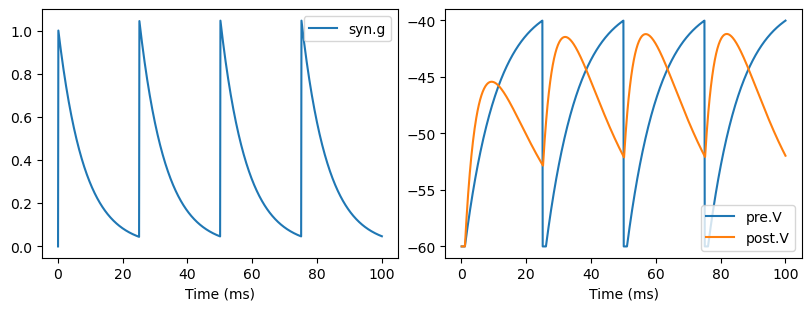

In [18]:
show_syn_model(ExpConnMat)

We can also use ``conn_mat`` to define an **AMPA synapse model**. Note here the shape of the synapse variable $g$ is ``(num_pre, num_post)``, rather than ``self.post.num`` in the above exponential synapse model. This is because the synaptic states of AMPA model can not be superposed. 

In [19]:
class AMPAConnMat(BaseAMPASyn):
  def __init__(self, *args, **kwargs):
    super(AMPAConnMat, self).__init__(*args, **kwargs)

    # connection matrix
    self.conn_mat = self.conn.require('conn_mat')

    # synapse gating variable
    # -------
    # NOTE: Here the synapse shape is (num_pre, num_post),
    #       in contrast to the ExpConnMat
    self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))

  def update(self, _t, _dt):
    # pull the delayed pre spikes for computation
    delayed_spike = self.pre_spike(self.delay_step)
    # push the latest pre spikes into the bottom
    self.pre_spike.update(self.pre.spike)
    # get the time of pre spikes arrive at the post synapse
    self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
    # get the neurotransmitter concentration at the current time
    TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
    # integrate the synapse state
    TT = TT.reshape((-1, 1)) * self.conn_mat  # NOTE: only keep the concentrations
                                              #       on the invalid connections
    self.g.value = self.integral(self.g, _t, TT, dt=_dt)
    # get the post-synaptic current
    g_post = self.g.sum(axis=0)
    self.post.input += self.g_max * g_post * (self.E - self.post.V)

  0%|          | 0/1000 [00:00<?, ?it/s]

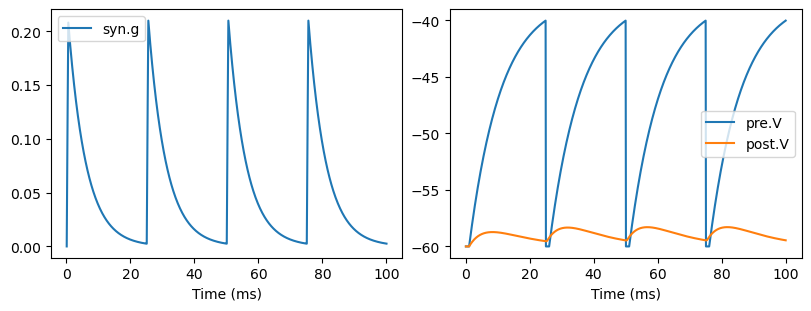

In [20]:
show_syn_model(AMPAConnMat)

### Special connections

Sometimes, we can define some synapse models with special connection types, such as all-to-all connection, or one-to-one connection. For these special situations, even the connection information can be ignored, i.e., we do not need ``conn_mat`` or other structures any more. 

Assume the pre-synaptic group connects to the post-synaptic group with a all-to-all fashion. 
Then, exponential synapse model can be defined as, 

In [21]:
class ExpAll2All(BaseExpSyn):
  def __init__(self, *args, **kwargs):
    super(ExpAll2All, self).__init__(*args, **kwargs)

    # synapse gating variable
    # -------
    # The synapse variable has the shape of the post-synaptic group
    self.g = bm.Variable(bm.zeros(self.post.num))

  def update(self, _t, _dt):
    delayed_spike = self.pre_spike(self.delay_step)
    self.pre_spike.update(self.pre.spike)
    self.g.value = self.integral(self.g, _t, dt=_dt)
    self.g += delayed_spike.sum()  # NOTE: HERE is the difference
    self.post.input += self.g_max * self.g * (self.E - self.post.V)

  0%|          | 0/1000 [00:00<?, ?it/s]

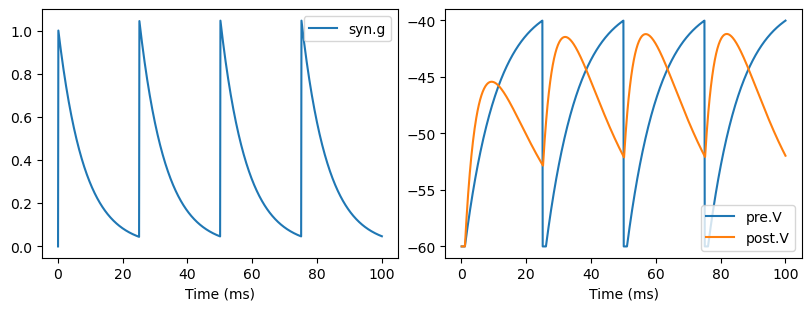

In [22]:
show_syn_model(ExpAll2All)

Similarly, the AMPA synapse model can be defined as

In [23]:
class AMPAAll2All(BaseAMPASyn):
  def __init__(self, *args, **kwargs):
    super(AMPAAll2All, self).__init__(*args, **kwargs)

    # synapse gating variable
    # -------
    # The synapse variable has the shape of the post-synaptic group
    self.g = bm.Variable(bm.zeros((self.pre.num, self.post.num)))

  def update(self, _t, _dt):
    delayed_spike = self.pre_spike(self.delay_step)
    self.pre_spike.update(self.pre.spike)
    self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
    TT = ((_t - self.spike_arrival_time) < self.T_duration) * self.T
    TT = TT.reshape((-1, 1))  # NOTE: here is the difference
    self.g.value = self.integral(self.g, _t, TT, dt=_dt)
    g_post = self.g.sum(axis=0) # NOTE: here is also different
    self.post.input += self.g_max * g_post * (self.E - self.post.V)

  0%|          | 0/1000 [00:00<?, ?it/s]

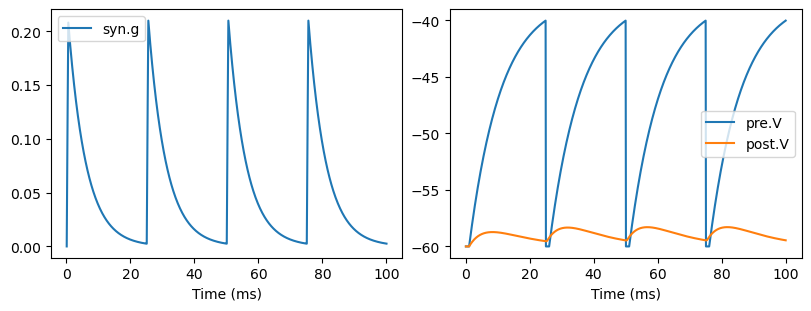

In [24]:
show_syn_model(AMPAAll2All)

Actually, the synaptic computation with these special connections can be very efficient! A concrete example please see a [decision making spiking model](https://brainpy-examples.readthedocs.io/en/latest/decision_making/Wang_2002_decision_making_spiking.html) in BrainPy-Examples. This implementation achievew at least four times acceleration comparing to the implementation in other frameworks. 

## Computation with Sparse Connections

However, in the real neural system, the neurons are connected **sparsely** in essence. 

Imaging you want to connect 10,000 pre-synaptic neurons to 10,000 post-synaptic neurons with a 10% random connection probability. Using matrix, you need $10^8$ floats to save the synaptic state, and at each update step, you need do computation on $10^8$ floats. Actually, the number of synapses you really connect is only $10^7$. See, there is a huge memory waste and computing resource inefficiency. Moreover, at the given time $\mathrm{\_t}$, the number of pre-synaptic neurons in the spiking state is small on average. This means we have made many useless computations when defining synaptic computations with matrix-based connections (zeros dot connection matrix results in zeros).

Therefore, we need new ways to define synapse models. Specifically, we use vectors to store the connected neuron indices, like the ``pre_ids`` and ``post_ids`` (see [Synaptic Connections](../tutorial_toolbox/synaptic_connections.ipynb)). 

In the below, we assume you have learned the synaptic connection types detailed in the tutorial of [Synaptic Connections](../tutorial_toolbox/synaptic_connections.ipynb).

### The ``pre2post`` operator

A notable difference of brain dynamics models from the deep learning is that they are sparse and event-driven. In order to support this significant different kind of computations, BrainPy has built many useful [operators](../apis/auto/math/operators.rst). In this section, we talk about a set of operators needed in ``pre2post`` computations. 

Note before we have said that exponential synapse model can make computations at the dimension of the post-synaptic group. Therefore, we can directly transform the pre-synaptic data into the data of the post-synaptic shape. [brainpy.math.pre2post_event_sum(events, pre2post, post_num, values)](../apis/auto/math/generated/brainpy.math.operators.pre2post_event_sum.rst) can satisfy your requirements. This operator needs the synaptic structure of ``pre2post`` (a tuple contains the ``post_ids`` and ``idnptr`` of pre-synaptic neurons). 

If ``values`` is a scalar, ``pre2post_event_sum`` is equivalent to:

```python
post_val = np.zeros(post_num)

post_ids, idnptr = pre2post
for i in range(pre_num):
  if events[i]:
    for j in range(idnptr[i], idnptr[i+1]):
      post_val[post_ids[i]] += values
```

If ``values`` is a vector, ``pre2post_event_sum`` is equivalent to:

```python
post_val = np.zeros(post_num)

post_ids, idnptr = pre2post
for i in range(pre_num):
  if events[i]:
    for j in range(idnptr[i], idnptr[i+1]):
      post_val[post_ids[i]] += values[j]
```

With this operator, exponential synapse model can be defined as:

In [25]:
class ExpSparse(BaseExpSyn):
  def __init__(self, *args, **kwargs):
    super(ExpSparse, self).__init__(*args, **kwargs)

    # connections
    self.pre2post = self.conn.require('pre2post')

    # synapse variable
    self.g = bm.Variable(bm.zeros(self.post.num))

  def update(self, _t, _dt):
    delayed_spike = self.pre_spike(self.delay_step)
    self.pre_spike.update(self.pre.spike)
    self.g.value = self.integral(self.g, _t, dt=_dt)
    # NOTE: update synapse states according to the pre spikes
    post_sps = bm.pre2post_event_sum(delayed_spike, self.pre2post, self.post.num, 1.)
    self.g += post_sps
    self.post.input += self.g_max * self.g * (self.E - self.post.V)

  0%|          | 0/1000 [00:00<?, ?it/s]

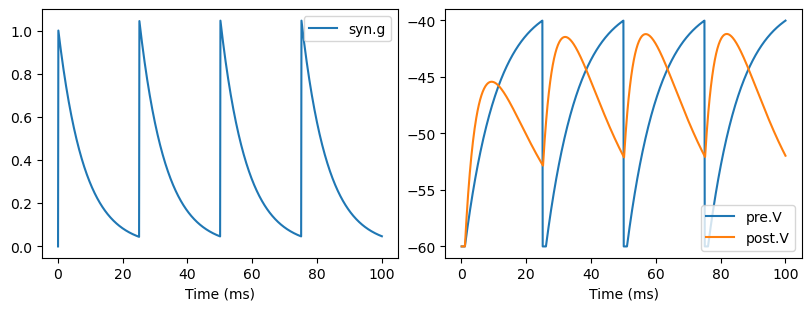

In [26]:
show_syn_model(ExpSparse)

This model will be very efficient when your synapses are connected sparsely. 

### The ``pre2syn`` and ``syn2post`` operators

However, for AMPA synapse model, the pre-synaptic values can not be directly transformed into the post-synaptic dimensional data. Therefore, we need to first change the pre data into the data of the synapse dimension, then transform the synapse-dimensional data into the post-dimensional data. 

Therefore, the core problem of synaptic computation is how to convert values among different shape of tensors. Specifically, in the above AMPA synapse model, we have three kinds of tensor shapes (see the following figure): tensors with the dimension of pre-synaptic group, tensors of the dimension of post-synaptic group, and tensors with the shape of synaptic connections. Converting the pre-synaptic spiking state into the synaptic state and grouping the synaptic variable as the post-synaptic current value are central problems of synaptic computation.

![](../_static/pre2syn2post.png)

Here BrainPy provides two operators [brainpy.math.pre2syn(pre_values, pre_ids)](../apis/auto/math/generated/brainpy.math.operators.pre2syn.rst) and [brainpy.math.syn2post(syn_values, post_ids, post_num)](../apis/auto/math/generated/brainpy.math.operators.syn2post.rst) to convert vectors among different dimensions.

- ``brainpy.math.pre2syn()`` receives two arguments: "pre_values" (the variable of the pre-synaptic dimension) and "pre_ids" (the connected pre-synaptic neuron index).
- ``brainpy.math.syn2post()`` receives three arguments: "syn_values" (the variable with the synaptic size), "post_ids" (the connected post-synaptic neuron index) and "post_num" (the number of the post-synaptic neurons).

Based on these two operators, we can define the AMPA synapse model as:

In [27]:
class AMPASparse(BaseAMPASyn):
  def __init__(self, *args, **kwargs):
    super(AMPASparse, self).__init__(*args, **kwargs)

    # connection matrix
    self.pre_ids, self.post_ids = self.conn.require('pre_ids', 'post_ids')

    # synapse gating variable
    # -------
    # NOTE: Here the synapse shape is (num_syn,)
    self.g = bm.Variable(bm.zeros(len(self.pre_ids)))

  def update(self, _t, _dt):
    delayed_spike = self.pre_spike(self.delay_step)
    self.pre_spike.update(self.pre.spike)
    # get the time of pre spikes arrive at the post synapse
    self.spike_arrival_time.value = bm.where(delayed_spike, _t, self.spike_arrival_time)
    # get the arrival time with the synapse dimension
    arrival_times = bm.pre2syn(self.spike_arrival_time, self.pre_ids)
    # get the neurotransmitter concentration at the current time
    TT = ((_t - arrival_times) < self.T_duration) * self.T
    # integrate the synapse state
    self.g.value = self.integral(self.g, _t, TT, dt=_dt)
    # get the post-synaptic current
    g_post = bm.syn2post(self.g, self.post_ids, self.post.num)
    self.post.input += self.g_max * g_post * (self.E - self.post.V)

  0%|          | 0/1000 [00:00<?, ?it/s]

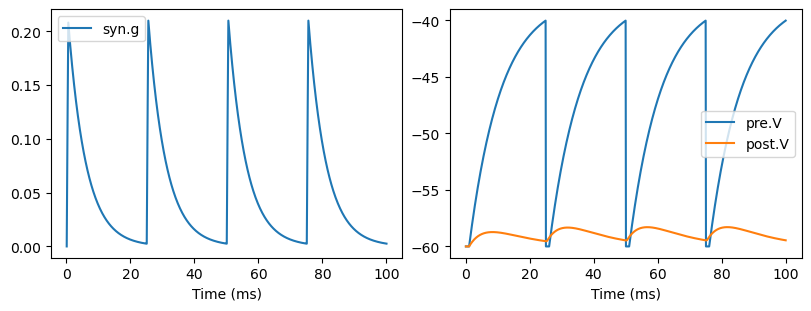

In [28]:
show_syn_model(AMPASparse)

We hope this tutorial will help your synapse models be defined efficiently. 